# Down-scaled multi-area model

#### Notebook structure <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Paramters specification](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
    * [1.2. Default parameters](#section_1_2)
* [S2. Multi-area model instantiation and simulation](#section_2)
    * [2.1. Insantiate a multi-area model](#section_2_1)
    * [2.2. Predict firing rates from theory](#section_2_2)
    * [2.3. Extract connectivity](#section_2_3)
    * [2.4. Run the simulation](#section_2_4)
* [S3. Data processing and simulation results analysis](#section_3)
* [S4. Simulation results visualization](#section_4) 

<br>

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import nest
from IPython.display import display, HTML

# Import the MultiAreaModel class
from multiarea_model import MultiAreaModel
from config import base_path


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: May 17 2023 20:48:31

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [3]:
!pip install nested_dict dicthash

In [4]:
# Jupyter notebook display format setting
style = """
<style>
table {float:left}
</style>
"""
display(HTML(style))

Go back to [Notebook structure](#toc)

<br>

## S1. Paramters specification <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

|Parameter                     |Default value            |Value range/options                                                   |Value assigned      |Description  |
|:----------------------------:|:-----------------------:|:--------------------------------------------------------------------:|:------------------:|:-----------:|
|scale_down_to                 |1.                       |(0, 1.]                                                               |0.005               |$^1$         |
|cc_weights_factor             |1.                       |(0, 1.]                                                               |1.                  |$^2$         |
|areas_simulated               |complete_area_list       |All sublists of complete_area_list                                    |complete_area_list  |$^3$         |
|replace_non_simulated_areas   |None                     |None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'   |'het_poisson_stat'  |$^4$         |

1. `scale_down_to` <br>
`scale_down_to` is the down-scaling factor which defines the the ratio of the full scale multi-area model being down-scaled to a model with fewer neurons and indegrees so as to be simulated on machines with lower computational ability and the simulation results can be obtained within relative shorter period of time. <br> Its deafualt value if 1. meaning full scale simulation. <br> In the pre-set downscale version, it's set as 0.005, where the numer of neurons and indegrees are both scaled down to 0.5% of its full scale amount, where the model can usually be simulated on a local machine. <br> **Warning**: This will not yield reasonable dynamical results from the network and is only meant to demonstrate the simulation workflow <br> 
2. `cc_weights_factor` <br>
This scaling factor controls the cortico-cortical synaptic strength. <br> By default it's set as 1.0, where the inter-area synaptic strength is the same as the intra-areal. <br> **Important**: This factor changes the network activity from ground state to metastable state. <br>
3. `areas_simulated` <br>
This parameter specifies the cortical areas included in the simulation process. Its default value is `complete_area_list` meaning all the areas in the complete_area_list will be actually simulated. <br>
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH'] <br>
The value assigned to simulation_areas can be any sublist of the `compete_area_list` specifying areas a user want to include in his/her simulation. <br>
4. `replace_non_simulated_areas` <br>
The paramter `replace_non_simulated_areas` defines how non-simulated areas will be replaced. <br> It's set as None by default when the parameter areas_simulated is set as full_area_list where all areas will be simulated so that no areas need to be replaced. <br> Other options are: 'hom_poisson_stat', 'het_poisson_stat', and 'het_current_nonstat'. 'hom_poisson_stat' is a manually set parameter which can be tuned. When it's set as 'het_poisson_stat' or 'het_current_nonstat', the data to replace the cortico-cortical input is loaded from 'replace_cc_input_source' which is the firing rates of our full scale simulation results. The differenc between 'het_poisson_stat' and 'het_current_nonstat' is that 'het_poisson_stat' is the mean of the time-series firing rate so that it's static, yet 'het_current_nonstat' is time-varying specific current, which is varying by time. 

In [5]:
# Downscaling factor
scale_down_to = 0.005 # Change it to 1. for running the fullscale network

# Scaling factor for cortico-cortical connections (chi) 
cc_weights_factor = 1.

# Cortical areas included in the simulation
areas_simulated = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']

# Firing rates used to replace the non-simulated areas
replace_non_simulated_areas = 'het_poisson_stat'

### 1.2. Default parameters <a class="anchor" id="section_1_2"></a>
We try our best not to confuse users with too many parameters. However, if you want to change more parameters and explore the model, you can do so by passing a dictionary to the `default_params` argument of the `MultiAreaModel` class.

In [6]:
# Connection parameters (conn_params)
conn_params = {
    # # It defines how non-simulated areas will be replaced
    # Whether to replace non-simulated areas by Poisson sources with the same global rate rate_ext ('hom_poisson_stat') or by specific rates ('het_poisson_stat') or by time-varying specific current ('het_current_nonstat'). In the two latter cases, the data to replace the cortico-cortical input is loaded from `replace_cc_input_source`
    'replace_non_simulated_areas': 'het_poisson_stat', 

    'g': -11.,
    'K_stable': 'K_stable.npy',
    # Increase the external input to 2/3E and 5E in area TH
    'fac_nu_ext_TH': 1.2,
    # Increase the external Poisson indegree onto 5E
    'fac_nu_ext_5E': 1.125,
    # Increase the external Poisson indegree onto 6E
    'fac_nu_ext_6E': 1.41666667,
    # Adjust the average indegree in V1 based on monkey data
    'av_indegree_V1': 3950.
}

# Input parameters (input_params)
input_params = {'rate_ext': 10.}

# Neuron parameters (neuron_params)
neuron_params = {'V0_mean': -150.,
                 'V0_sd': 50.}

# Network parameters (network_params)
network_params = {'N_scaling': scale_down_to,
                  'K_scaling': scale_down_to,
                  'fullscale_rates': 'tests/fullscale_rates.json',
                  'input_params': input_params,
                  'connection_params': conn_params,
                  'neuron_params': neuron_params}

# Simulation parameters (sim_params)
sim_params = {'t_sim': 2000.,
              'num_processes': 1,
              'local_num_threads': 1,
              'recording_dict': {'record_vm': False},
              'rng_seed': 1} # global random seed

# Theory paramters (theory_params)
theory_params = {'dt': 0.1}

Go back to [Notebook structure](#toc)

<br>

## S2. Multi-area model instantiation and simulation <a class="anchor" id="section_2"></a>

### 2.1. Insantiate a multi-area model <a class="anchor" id="section_2_1"></a>

In [7]:
M = MultiAreaModel(network_params, simulation=True,
                   sim_spec=sim_params,
                   theory=True,
                   theory_spec=theory_params)

Initializing network from dictionary.
RAND_DATA_LABEL 3497


/srv/main-spack-instance-2302/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.21.6-6fewtq7oarp3vtwlxrrcofz5sxwt55s7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:Mean of empty slice.
/srv/main-spack-instance-2302/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.21.6-6fewtq7oarp3vtwlxrrcofz5sxwt55s7/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning:invalid value encountered in double_scalars
Error in library("aod") : there is no package called ‘aod’
Execution halted


No R installation or IndexError, taking hard-coded SLN fit parameters.


Customized parameters
--------------------
{'K_scaling': 0.005,
 'N_scaling': 0.005,
 'connection_params': {'K_stable': 'K_stable.npy',
                       'av_indegree_V1': 3950.0,
                       'fac_nu_ext_5E': 1.125,
                       'fac_nu_ext_6E': 1.41666667,
                       'fac_nu_ext_TH': 1.2,
                       'g': -11.0,
                       'replace_non_simulated_areas': 'het_poisson_stat'},
 'fullscale_rates': 'tests/fullscale_rates.json',
 'input_params': {'rate_ext': 10.0},
 'neuron_params': {'V0_mean': -150.0, 'V0_sd': 50.0}}


/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/dicthash/dicthash.py:47: UserWarning:Float too small for safe conversion tointeger. Rounding down to zero.


Simulation label: 27d81076e6d6e9e591684be053078477
Copied files.
Initialized simulation class.


### 2.2. Predict firing rates from theory <a class="anchor" id="section_2_2"></a>

In [8]:
p, r = M.theory.integrate_siegert()
print("Mean-field theory predicts an average "
      "rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Iteration: 0
Mean-field theory predicts an average rate of 29.588 spikes/s across all populations.


### 2.3. Extract connectivity <a class="anchor" id="section_2_3"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. Neuron numbers are stored in `M.N` as a dictionary (and in `M.N_vec` as an array), indegrees in `M.K` as a dictionary (and in `M.K_matrix` as an array). Number of synapses can also be access via `M.synapses` (and in `M.syn_matrix` as an array). <br>

**Warning**: memory explosion

#### 2.3.1 Node indegrees

In [9]:
# Dictionary of nodes indegrees organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: indegree_values}}}}
# M.K

#### 2.3.2 Synapses

In [10]:
# Dictionary of synapses that target neurons receive, it is organized as:
# {<source_area>: {<source_pop>: {<target_area>: {<target_pop>: number_of_synapses}}}}
# M.synapses

Go back to [Notebook structure](#toc)

<br>

### 2.4. Run the simulation <a class="anchor" id="section_2_4"></a>

In [11]:
# run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
M.simulation.simulate()

Prepared simulation in 0.00 seconds.
Rank 0: created area V1 with 0 local nodes
Memory after V1 : 1912.20 MB
Rank 0: created area V2 with 0 local nodes
Memory after V2 : 1938.80 MB
Rank 0: created area VP with 0 local nodes
Memory after VP : 1967.95 MB
Rank 0: created area V3 with 0 local nodes
Memory after V3 : 1996.29 MB
Rank 0: created area V3A with 0 local nodes
Memory after V3A : 2016.27 MB
Rank 0: created area MT with 0 local nodes
Memory after MT : 2041.77 MB
Rank 0: created area V4t with 0 local nodes
Memory after V4t : 2066.75 MB
Rank 0: created area V4 with 0 local nodes
Memory after V4 : 2093.70 MB
Rank 0: created area VOT with 0 local nodes
Memory after VOT : 2119.05 MB
Rank 0: created area MSTd with 0 local nodes
Memory after MSTd : 2140.52 MB
Rank 0: created area PIP with 0 local nodes
Memory after PIP : 2161.88 MB
Rank 0: created area PO with 0 local nodes
Memory after PO : 2183.38 MB
Rank 0: created area DP with 0 local nodes
Memory after DP : 2203.54 MB
Rank 0: created

Go back to [Notebook structure](#toc)

<br>

## S3. Data processing and simulation results analysis <a class="anchor" id="section_3"></a>

The following instructions will work when the `simulate` parameter is set to `True` during the creation of the MultiAreaModel object, and the `M.simulation.simulate()` method is executed.

In [12]:
# Uncomment the lines in this code cell below to test if the number of synapses created by NEST matches the expected values

# """
# Test if the correct number of synapses has been created.
# """
# print("Testing synapse numbers")
# for target_area_name in M.area_list:
#     target_area = M.simulation.areas[M.simulation.areas.index(target_area_name)]
#     for source_area_name in M.area_list:
#         source_area = M.simulation.areas[M.simulation.areas.index(source_area_name)]
#         for target_pop in M.structure[target_area.name]:
#             target_nodes = target_area.gids[target_pop]
#             for source_pop in M.structure[source_area.name]:
#                 source_nodes = source_area.gids[source_pop]
#                 created_syn = nest.GetConnections(source=source_nodes,
#                                                   target=target_nodes)
#                 syn = M.synapses[target_area.name][target_pop][source_area.name][source_pop]
#                 assert(len(created_syn) == int(syn))

To obtain the connections information, you can extract the lists of connected sources and targets. Moreover, you can access additional synaptic details, such as synaptic weights and delays.

In [13]:
# conns = nest.GetConnections()
# conns_sparse_matrix = conns.get(['source', 'target', 'weight'])

# srcs = conns_sparse_matrix['source']
# tgts = conns_sparse_matrix['target']
# weights = conns_sparse_matrix['weight']

You can determine the area and subpopulation to which the neuron ID ranges belong by referring to the file `network_gids.txt`, which is automatically generated during network creation.

In [14]:
# # Open the file using a with statement
# with open(os.path.join(M.simulation.data_dir,"recordings/network_gids.txt"), "r") as file:
#     # Read the contents of the file
#     gids = file.read()

# # Print the contents
# print(gids)

### 1. Load spike data

In [15]:
data = np.loadtxt(M.simulation.data_dir + '/recordings/' + M.simulation.label + "-spikes-1-0.dat", skiprows=3)

### 2. Compute instantaneous rate per neuron across all populations

In [16]:
tsteps, spikecount = np.unique(data[:,1], return_counts=True)
rate = spikecount / M.simulation.params['dt'] * 1e3 / np.sum(M.N_vec)

Go back to [Notebook structure](#toc)

<br>

## S4. Simulation results visualization <a class="anchor" id="section_4"></a>

### 4.1. Instantaneous and mean rate
avaerage over all areas

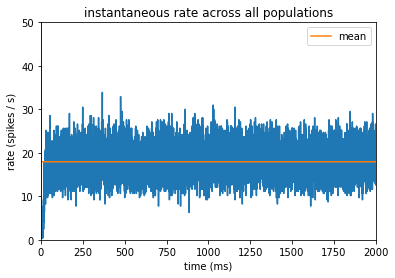

In [17]:
fig, ax = plt.subplots()
ax.plot(tsteps, rate)
ax.plot(tsteps, np.average(rate)*np.ones(len(tsteps)), label='mean')
ax.set_title('instantaneous rate across all populations')
ax.set_xlabel('time (ms)')
ax.set_ylabel('rate (spikes / s)')
ax.set_xlim(0, sim_params['t_sim'])
ax.set_ylim(0, 50)
ax.legend()

### 4.2 Raster plot of spiking activity for single area
Raster plot of spiking activity of 3% of the neurons in area V1 (A), V2 (B), and FEF (C). Blue: excitatory neurons, red: inhibitory neurons. (D-F) Spiking statistics across all 32 areas for the respective populations shown as area-averaged box plots. Crosses: medians, boxes: interquartile range (IQR), whiskers extend to the most extremeobservat ions within 1.5×IQR beyond the IQR.

In [18]:
"""
Create raster display of a single area with populations stacked
onto each other. Excitatory neurons in blue, inhibitory
neurons in red.

Parameters
----------
area : string {area}
    Area to be plotted.
frac_neurons : float, [0,1]
    Fraction of cells to be considered.
t_min : float, optional
    Minimal time in ms of spikes to be shown. Defaults to 0 ms.
t_max : float, optional
    Minimal time in ms of spikes to be shown. Defaults to simulation time.
output : {'pdf', 'png', 'eps'}, optional
    If given, the function stores the plot to a file of the given format.

"""

    def init_analysis(self, ana_spec):
        assert(hasattr(self, 'simulation'))
        if 'load_areas' in ana_spec:
            load_areas = ana_spec['load_areas']
        else:
            load_areas = None
        if 'data_list' in ana_spec:
            data_list = ana_spec['data_list']
        else:
            data_list = ['spikes']
        self.analysis = Analysis(self, self.simulation,
                                 data_list=data_list,
                                 load_areas=load_areas)
        
area = 'V1'
frac_neurons = 0.03
M.analysis.single_dot_display(area,  frac_neurons, t_min=500., t_max='T')

area = 'V2'
frac_neurons = 0.03
M.analysis.single_dot_display(area,  frac_neurons, t_min=500., t_max='T')

area = 'FEF'
frac_neurons = 0.03
M.analysis.single_dot_display(area,  frac_neurons, t_min=500., t_max='T')

AttributeError: 'MultiAreaModel' object has no attribute 'analysis'

### 4.3 Population-averaged firing rates

In [ ]:
"""
Calculate time-averaged population rates and store them in member pop_rates.
If the rates had previously been stored with the same
parameters, they are loaded from file.

Parameters
----------
t_min : float, optional
    Minimal time in ms of the simulation to take into account
    for the calculation. Defaults to 500 ms.
t_max : float, optional
    Maximal time in ms of the simulation to take into account
    for the calculation. Defaults to the simulation time.
compute_stat : bool, optional
    If set to true, the mean and variance of the population rate
    is calculated. Defaults to False.
    Caution: Setting to True slows down the computation.
areas : list, optional
    Which areas to include in the calculcation.
    Defaults to all loaded areas.
pops : list or {'complete'}, optional
    Which populations to include in the calculation.
    If set to 'complete', all populations the respective areas
    are included. Defaults to 'complete'.
"""
M.analysis.create_pop_rates(t_min=1000.)
# M.analysis.save()

### 4.4 Average pairwise correlation coefficients of spiking activity

### 4.5 Irregularity measured by revised local variation LvR averaged across neurons

### 4.6 Time series of population- and area-averaged firing rates
Area-averaged firing rates, shown as raw binned spike histograms with 1ms bin width (gray) and convolved histograms, with aGaussian kernel (black) of optimal width

In [ ]:
"""
Calculate time series of population- and area-averaged firing rates.
Uses ah.pop_rate_time_series.
If the rates have previously been stored with the
same parameters, they are loaded from file.


Parameters
----------
t_min : float, optional
    Minimal time in ms of the simulation to take into account
    for the calculation. Defaults to 500 ms.
t_max : float, optional
    Maximal time in ms of the simulation to take into account
    for the calculation. Defaults to the simulation time.
areas : list, optional
    Which areas to include in the calculcation.
    Defaults to all loaded areas.
pops : list or {'complete'}, optional
    Which populations to include in the calculation.
    If set to 'complete', all populations the respective areas
    are included. Defaults to 'complete'.
kernel : {'gauss_time_window', 'alpha_time_window', 'rect_time_window'}, optional
    Specifies the kernel to be convolved with the spike histogram.
    Defaults to 'binned', which corresponds to no convolution.
resolution: float, optional
    Width of the convolution kernel. Specifically it correponds to:
    - 'binned' : bin width of the histogram
    - 'gauss_time_window' : sigma
    - 'alpha_time_window' : time constant of the alpha function
    - 'rect_time_window' : width of the moving rectangular function
"""
M.analysisi.create_rate_time_series(t_max=1000.)
# M.analysis.save()

Go back to [Notebook structure](#toc)